In [2]:
import pymongo, pandas as pd
from pymongo import MongoClient

In [3]:
conn="mongodb://localhost:27017"
client=MongoClient(conn)

In [4]:
df=pd.read_csv('Housing.csv')
df

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished
...,...,...,...,...,...,...,...,...,...,...,...,...,...
540,1820000,3000,2,1,1,yes,no,yes,no,no,2,no,unfurnished
541,1767150,2400,3,1,1,no,no,no,no,no,0,no,semi-furnished
542,1750000,3620,2,1,1,yes,no,no,no,no,0,no,unfurnished
543,1750000,2910,3,1,1,no,no,no,no,no,0,no,furnished


In [5]:
db=client["Housing1"]
collection=db["Hcollection1"]
collectlist=df.to_dict('records')
collection.insert_many(collectlist)

In [6]:
alldocs=collection.find({'price':{"$gt":1000000}},{'_id':0}).sort("price")
for i in alldocs:
    print(i)

{'price': 1750000, 'area': 3620, 'bedrooms': 2, 'bathrooms': 1, 'stories': 1, 'mainroad': 'yes', 'guestroom': 'no', 'basement': 'no', 'hotwaterheating': 'no', 'airconditioning': 'no', 'parking': 0, 'prefarea': 'no', 'furnishingstatus': 'unfurnished'}
{'price': 1750000, 'area': 2910, 'bedrooms': 3, 'bathrooms': 1, 'stories': 1, 'mainroad': 'no', 'guestroom': 'no', 'basement': 'no', 'hotwaterheating': 'no', 'airconditioning': 'no', 'parking': 0, 'prefarea': 'no', 'furnishingstatus': 'furnished'}
{'price': 1750000, 'area': 3850, 'bedrooms': 3, 'bathrooms': 1, 'stories': 2, 'mainroad': 'yes', 'guestroom': 'no', 'basement': 'no', 'hotwaterheating': 'no', 'airconditioning': 'no', 'parking': 0, 'prefarea': 'no', 'furnishingstatus': 'unfurnished'}
{'price': 1750000, 'area': 3620, 'bedrooms': 2, 'bathrooms': 1, 'stories': 1, 'mainroad': 'yes', 'guestroom': 'no', 'basement': 'no', 'hotwaterheating': 'no', 'airconditioning': 'no', 'parking': 0, 'prefarea': 'no', 'furnishingstatus': 'unfurnished'}

In [7]:
# Aggregation pipeline
pipeline = [
    {"$match": {"mainroad": {"$in": ["yes", "no"]}}},  # Filter valid values
    {"$project": {
        "price": 1,
        "area": 1,
        "bedrooms": 1,
        "bathrooms": 1,
        "guestroom":{
            "$cond":[
                {"$eq":["$guestroom","yes"]},
                1,
                0]
        },
        "basement":{
            "$cond":[
                {"$eq":["$basement","yes"]},
                1,
                0]
        },
        "hotwatering":{
            "$cond":[
                {"$eq":["$hotwatering","yes"]},
                1,
                0]
        },
        "airconditioning":{
            "$cond":[
                {"$eq":["$airconditioning","yes"]},
                1,
                0]
        },
        "prefarea":{
            "$cond":[
                {"$eq":["$prefarea","yes"]},
                1,
                0]
        },
        "furnishingstatus": {
            "$cond": [
                {"$eq": ["$furnishingstatus", "fully-furnished"]},
                2,
                {
                    "$cond": [
                        {"$eq": ["$furnishingstatus", "semi-furnished"]},
                        1,
                        0
                    ]
                }
            ]
        },

        "mainroad": {
            "$cond": [
                {"$eq": ["$mainroad", "yes"]},
                1,
                0
            ]
        }
    }},
    {"$group": {
        "_id": {"price": "$price", "stories":"$stories","area": "$area", "bedrooms": "$bedrooms", "bathrooms": "$bathrooms","guestroom":"$guestroom",'basement':'$basement','hotwaterheating':'$hotwaterheating','airconditioning':'$airconditioning', 'parking':'$parking','prefarea':'$prefarea','furnishingstatus':'$furnishingstatus'},
        "average_price_per_area": {"$avg": {"$divide": ["$price", "$area"]}},
    }},
    {"$sort": {"average_price_per_area": 1}},
    {"$project": {
        "_id": 0,  # Exclude the _id field from the output
        "price": "$_id.price",
        "area": "$_id.area",
        "bedrooms": "$_id.bedrooms",
        'hotwaterheating':'$_id.hotwaterheating',
        'airconditioning':'$_id.airconditioning',
        "bathrooms": "$_id.bathrooms",
        "guestroom":"$_id.guestroom",
        'prefarea':'$_id.prefarea',
        "stories":"$_id.stories",
        "mainroad": 1,
        "furnishingstatus": "$_id.furnishingstatus",
        "average_price_per_area": 1
    }}
]
result = list(collection.aggregate(pipeline))

# Convert the result to a DataFrame
result_df = pd.DataFrame(result)

# Print the DataFrame
print(result_df)
result_df.to_csv('filtered_data.csv')
client.close()

     average_price_per_area    price   area  bedrooms  airconditioning  \
0                270.395550  3500000  12944         3                0   
1                318.181818  2450000   7700         2                0   
2                350.000000  3150000   9000         3                0   
3                368.421053  3500000   9500         3                0   
4                373.043478  3003000   8050         2                0   
..                      ...      ...    ...       ...              ...   
539             1958.041958  4200000   2145         3                0   
540             1963.218391  4270000   2175         3                1   
541             2025.462963  8750000   4320         3                0   
542             2278.215223  4340000   1905         5                0   
543             2640.000000  9240000   3500         4                0   

     bathrooms  guestroom  prefarea  furnishingstatus  
0            1          0         0                 0  

In [94]:
import pandas as pd

# Load the data
test_df = pd.read_csv("filtered_data.csv")

# Perform data cleaning and imputation
# ...
test_df

,Unnamed: 0,average_price_per_area,price,area,bedrooms,airconditioning,bathrooms,guestroom,prefarea,furnishingstatus
0,0,270.395550,3500000,12944,3,0,1,0,0,0
1,1,318.181818,2450000,7700,2,0,1,0,0,0
2,2,350.000000,3150000,9000,3,0,1,0,0,1
3,3,368.421053,3500000,9500,3,0,1,0,1,0
4,4,373.043478,3003000,8050,2,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...
539,539,1958.041958,4200000,2145,3,0,1,0,1,0
540,540,1963.218391,4270000,2175,3,1,1,1,0,0
541,541,2025.462963,8750000,4320,3,0,1,0,0,1
542,542,2278.215223,4340000,1905,5,0,1,0,0,1


In [8]:
import pandas as pd

# Load the data and drop the "unnamed:0" column
data = pd.read_csv("filtered_data.csv")
data = data.drop(columns=["Unnamed: 0"])

# Display the shape of the loaded data
print("Shape of the data:", data.shape)

Shape of the data: (544, 9)


In [9]:
import pandas as pd
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor

# Load the data
data = data


# Define features and target variable
X = data.drop(columns=["price"])  # Assuming "price" is the target column
y = data["price"]

# Initialize the base model for RFE
base_model = RandomForestRegressor()

# Initialize RFE and fit it to the data
num_features_to_select = 8  # Choose the desired number of features
rfe = RFE(estimator=base_model, n_features_to_select=num_features_to_select)
rfe.fit(X, y)

# Get the selected features
selected_features_rfe = X.columns[rfe.support_]

print("Selected features:", selected_features_rfe)


Selected features: Index(['average_price_per_area', 'area', 'bedrooms', 'airconditioning',
       'bathrooms', 'guestroom', 'prefarea', 'furnishingstatus'],
      dtype='object')


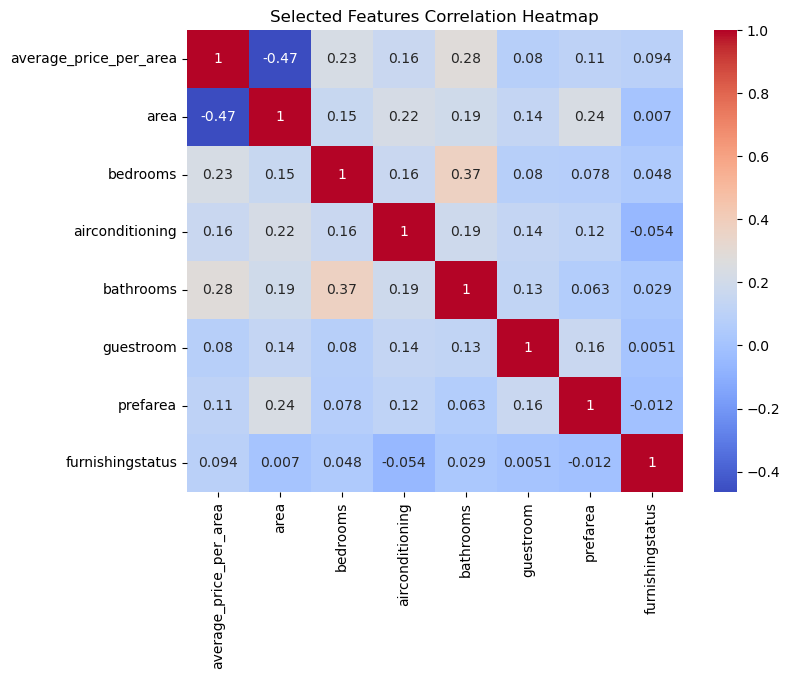

In [10]:
import matplotlib.pyplot as plt 
import seaborn as sns
selected_features_rfe = X.columns[rfe.support_]

# Calculate correlations for selected features
selected_features_correlation = X[selected_features_rfe].corr()

# Visualize correlations using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(selected_features_correlation, annot=True, cmap="coolwarm")
plt.title("Selected Features Correlation Heatmap")
plt.show()

In [11]:
from sklearn.decomposition import PCA
from statsmodels.stats.outliers_influence import variance_inflation_factor
# Calculate VIF for selected features
X_selected = X[selected_features_rfe]
vif_data = pd.DataFrame()
vif_data["Feature"] = X_selected.columns
vif_data["VIF"] = [variance_inflation_factor(X_selected.values, i) for i in range(len(X_selected.columns))]

# Apply PCA to make selected features uncorrelated
pca = PCA()
X_pca = pca.fit_transform(X_selected)

# Variance explained by each principal component
explained_variance_ratio = pca.explained_variance_ratio_

print("Variance explained by each principal component:", explained_variance_ratio)

Variance explained by each principal component: [9.80640832e-01 1.93588801e-02 1.01195576e-07 5.14677905e-08
 3.86847454e-08 3.74148484e-08 3.30627489e-08 2.63950994e-08]


In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# Scale the PCA-transformed data using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [14]:
import pandas as pd
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import joblib
y = data["price"]

# Choose the features
X = data.drop(columns=["price"])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply MinMax scaling to the features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train XGBoost model
xgb_model = XGBRegressor()
xgb_model.fit(X_train_scaled, y_train)


# Define a function to create your LSTM model
def create_lstm_model():
    model = Sequential([
        LSTM(units=50, activation='relu', input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Wrap the Keras model using KerasRegressor
lstm_estimator = KerasRegressor(build_fn=create_lstm_model, epochs=100, batch_size=64, verbose=0)

# Use TimeSeriesSplit for cross-validation
cv = TimeSeriesSplit(n_splits=10)



# Define models with corresponding hyperparameters
models = {
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "Linear Regression": LinearRegression(),
    "XGBoost": XGBRegressor(),
    "Random Forest": RandomForestRegressor(),
    "LSTM": lstm_estimator  # Use the wrapped Keras model
}

# Perform cross-validation to evaluate models
scores = {}

for model_name, model in models.items():
    if isinstance(model, KerasRegressor):  # Check if the model is the LSTM estimator
        cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring='neg_mean_squared_error')
        cv_score = -cv_scores.mean()  # Invert the sign to make scores positive
    else:
        cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring='neg_mean_squared_error')
        cv_score = -cv_scores.mean()  # Invert the sign to make scores positive
    
    scores[model_name] = cv_score

# Find the best model
best_model_name = min(scores, key=scores.get)
print("Best model:", best_model_name)
try:
    scores = cross_val_score(best_model_name, X_train_scaled, y_train, scoring="neg_mean_squared_error", cv=10, error_score='raise')
except Exception as e:
    print("Fit failed during cross-validation:", str(e))


# Train the selected best model on the entire dataset
best_model = models[best_model_name]
if isinstance(best_model, KerasRegressor):
    best_model.fit(X_test_scaled, y_train, epochs=10, batch_size=32, verbose=0)
else:
    best_model.fit(X_train_scaled, y_train)
# Save the selected best model
joblib.dump(best_model, "best_model.pkl")

# Use the best model for predictions
if isinstance(best_model, KerasRegressor):
    y_pred = best_model.predict(X_test_scaled)
else:
    y_pred = best_model.predict(X_test_scaled)

# Evaluate the model using appropriate metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Model Evaluation:")
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared (R2):", r2)

# Show the input features and predicted outputs
for i in range(len(y_pred)):
    print("Input:", X_test.iloc[i])
    print("Predicted Price:", y_pred[i])
    print()

C:\Users\Hp\AppData\Local\Temp\ipykernel_32656\4144996293.py:42: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_estimator = KerasRegressor(build_fn=create_lstm_model, epochs=100, batch_size=64, verbose=0)


Best model: XGBoost
Fit failed during cross-validation: estimator should be an estimator implementing 'fit' method, 'XGBoost' was passed
Model Evaluation:
Mean Squared Error (MSE): 172902338315.40884
Mean Absolute Error (MAE): 236000.60779816515
R-squared (R2): 0.9644779867694165
Input: average_price_per_area    1292.011019
area                      3630.000000
bedrooms                     3.000000
airconditioning              0.000000
bathrooms                    1.000000
guestroom                    0.000000
prefarea                     0.000000
furnishingstatus             1.000000
Name: 457, dtype: float64
Predicted Price: 4545239.5

Input: average_price_per_area     933.333333
area                      4500.000000
bedrooms                     3.000000
airconditioning              0.000000
bathrooms                    1.000000
guestroom                    0.000000
prefarea                     0.000000
furnishingstatus             0.000000
Name: 257, dtype: float64
Predicted Price: 

c:\Users\Hp\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
10 fits failed out of a total of 10.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Hp\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Hp\anaconda3\lib\site-packages\keras\wrappers\scikit_learn.py", line 164, in fit
    self.model = self.build_fn(**self.filter_sk_params(self.build_fn))
  File "C:\Users\Hp\AppData\Local\Temp\ipykernel_32656\4144996293.py", line 35, in create_lstm_model
    LSTM(units=50, activation='relu', input_sh

In [105]:
loaded_model = joblib.load("best_model.pkl")

# Load the new data for testing (replace 'test_data.csv' with your new data file name)
new_data = pd.read_csv("filtered_data.csv")

# Assuming you've already performed the same feature selection, PCA, and scaling steps as before
selected_features_rfe = ['average_price_per_area', 'area', 'bedrooms', 'airconditioning', 'bathrooms', 'guestroom', 'prefarea', 'furnishingstatus'] # Your selected features
pca = PCA()
X_pca = pca.fit_transform(new_data[selected_features_rfe])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_pca)

# Make predictions using the loaded model
predictions = loaded_model.predict(X_scaled)

# Print test inputs and predicted outputs
for i in range(len(predictions)):
    print("Test Input:", new_data.iloc[i])
    print("Predicted Price:", predictions[i])

Test Input: Unnamed: 0                0.000000e+00
average_price_per_area    2.703956e+02
price                     3.500000e+06
area                      1.294400e+04
bedrooms                  3.000000e+00
airconditioning           0.000000e+00
bathrooms                 1.000000e+00
guestroom                 0.000000e+00
prefarea                  0.000000e+00
furnishingstatus          0.000000e+00
Name: 0, dtype: float64
Predicted Price: 4781075.0
Test Input: Unnamed: 0                1.000000e+00
average_price_per_area    3.181818e+02
price                     2.450000e+06
area                      7.700000e+03
bedrooms                  2.000000e+00
airconditioning           0.000000e+00
bathrooms                 1.000000e+00
guestroom                 0.000000e+00
prefarea                  0.000000e+00
furnishingstatus          0.000000e+00
Name: 1, dtype: float64
Predicted Price: 4791141.0
Test Input: Unnamed: 0                      2.0
average_price_per_area        350.0
price     

In [103]:
from pymongo import MongoClient
import pandas as pd
import joblib
from sklearn.preprocessing import StandardScaler
conn="mongodb://localhost:27017"
client=MongoClient(conn)
# Load the saved model
loaded_model = joblib.load("best_model.pkl")

# Take user input for 'main_road'
main_road = input("Is the main road (1 for yes, 0 for no)? ")
main_road = int(main_road)

if main_road == 1:
    # Create a dictionary with the input features
    input_data = {
        'average_price_per_area': float(input("Enter average price per area: ")),
        'area': float(input("Enter area: ")),
        'bedrooms': int(input("Enter number of bedrooms: ")),
        'airconditioning': int(input("Is there air conditioning (1 for yes, 0 for no)? ")),
        'bathrooms': int(input("Enter number of bathrooms: ")),
        'guestroom': int(input("Is there a guest room (1 for yes, 0 for no)? ")),
        'prefarea': int(input("Is it a preferred area (1 for yes, 0 for no)? ")),
        'furnishingstatus': int(input("Enter furnishing status (2 for fully, 1 for semi, 0 for none): "))
    }

    # Convert the input dictionary to a DataFrame
    input_df = pd.DataFrame([input_data])

    # Replace this with your actual selected features obtained from feature selection
    selected_features = ["average_price_per_area", "area", "bedrooms", "airconditioning", "bathrooms", "guestroom", "prefarea", "furnishingstatus"]

    # Apply the same scaling steps as before
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(input_df[selected_features])

    # Make predictions using the loaded model
    predictions = loaded_model.predict(X_scaled)

    print("Predicted Price:", predictions[0])

    # Insert the input data into MongoDB collection
    client = MongoClient("mongodb://localhost:27017/")
    db = client["Housing_Result"]
    collection = db["HcollResult"]

    input_dict = input_data.copy()
    input_dict['Predicted'] = f'Rs. {predictions[0]}'

    # Insert the dictionary into the collection
    collection.insert_one(input_dict)

else:
    print("Main road is not selected, so prediction is not applicable.")
client.close()

Predicted Price: 1524962.6
